In [1]:
import sys
import qiskit
import qiskit_ibm_runtime

print("Python executable:", sys.executable)
print("Qiskit module:", qiskit)

Python executable: C:\Users\Ramwani\anaconda3\python.exe
Qiskit module: <module 'qiskit' from 'C:\\Users\\Ramwani\\anaconda3\\Lib\\site-packages\\qiskit\\__init__.py'>


In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
    token="t6fNsm6_XkyXRISIIg8j3HaeguCzks-G5-ReWwp69Ous",
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/c376f2a19a444b5ab5eb1af2bb6fcfc7:433c4c0b-585b-476c-989d-6c5a25d7a976::",
    channel="ibm_quantum_platform",
    set_as_default=True,
    overwrite=True        # <— add this
)

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Remove any previously saved (bad) account
QiskitRuntimeService.delete_account()

True

In [6]:
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService

service = QiskitRuntimeService()  # uses the new saved account

backend = service.least_busy(operational=True, min_num_qubits=3)
print("Using backend:", backend.name)
backend

Using backend: ibm_fez


<IBMBackend('ibm_fez')>

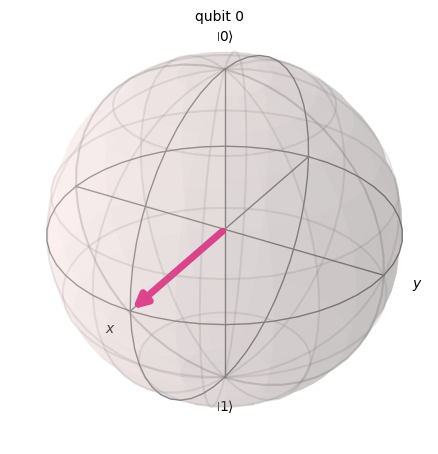

In [7]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector

# Create a 1-qubit circuit
qc_bloch = QuantumCircuit(1)

# Prepare |+> state
qc_bloch.h(0)

# Get statevector
state = Statevector.from_instruction(qc_bloch)

# Plot Bloch sphere
plot_bloch_multivector(state)


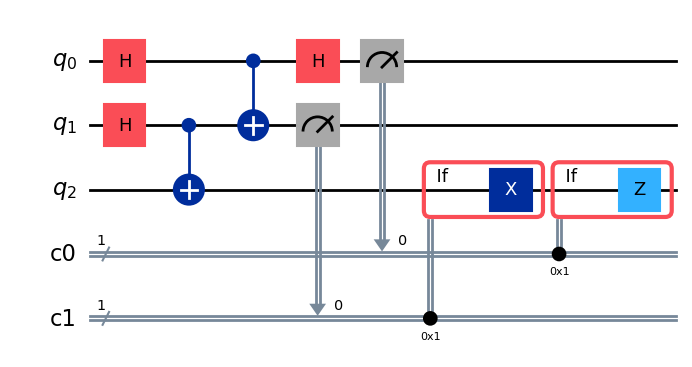

In [8]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Quantum register with 3 qubits
q = QuantumRegister(3, "q")

# Classical registers for Alice's measurements
c0 = ClassicalRegister(1, "c0")
c1 = ClassicalRegister(1, "c1")

# Build the teleportation circuit
teleportation_circuit = QuantumCircuit(q, c0, c1, name="quantum_teleportation")

# Step 1: Prepare the state to teleport (|+>)
teleportation_circuit.h(q[0])

# Step 2: Create Bell pair between q1 and q2
teleportation_circuit.h(q[1])
teleportation_circuit.cx(q[1], q[2])

# Step 3: Entangle q0 with q1
teleportation_circuit.cx(q[0], q[1])
teleportation_circuit.h(q[0])

# Step 4: Measure Alice's qubits
teleportation_circuit.measure(q[0], c0[0])
teleportation_circuit.measure(q[1], c1[0])

# Step 5: Conditional corrections on Bob's qubit
with teleportation_circuit.if_test((c1, 1)):
    teleportation_circuit.x(q[2])

with teleportation_circuit.if_test((c0, 1)):
    teleportation_circuit.z(q[2])

# Visualize circuit
teleportation_circuit.draw("mpl")


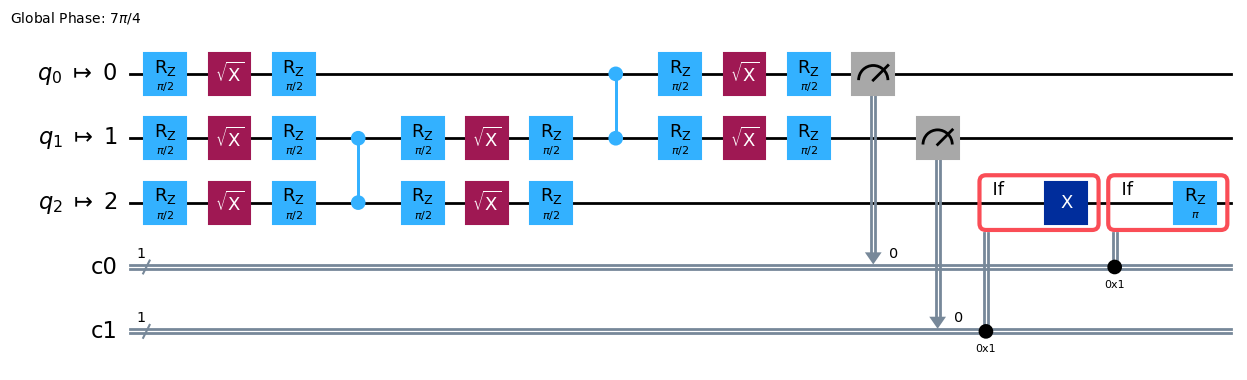

In [14]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

# Load IBM Quantum service
service = QiskitRuntimeService()

# Select backend (example: least busy real backend)
backend = service.least_busy(simulator=False, operational=True)

# Generate pass manager
pm = generate_preset_pass_manager(
    backend=backend,
    optimization_level=1
)

# Transpile circuit
isa_circuit = pm.run(teleportation_circuit)

# Draw transpiled circuit
isa_circuit.draw("mpl")


Job ID: d51eco7p3tbc73akec7g


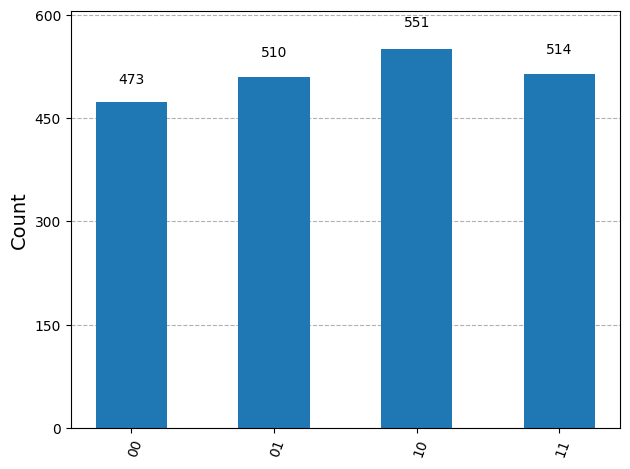

In [10]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import plot_histogram

# Create sampler bound to backend
sampler = Sampler(mode=backend)

# Set number of shots
sampler.options.default_shots = 2048

# Run job
job = sampler.run([isa_circuit])

print("Job ID:", job.job_id())

# Retrieve results
pub_result = job.result()[0]
counts = pub_result.join_data().get_counts()

# Plot results
plot_histogram(counts)


Bitstring counts: {'10': 551, '01': 510, '11': 514, '00': 473}


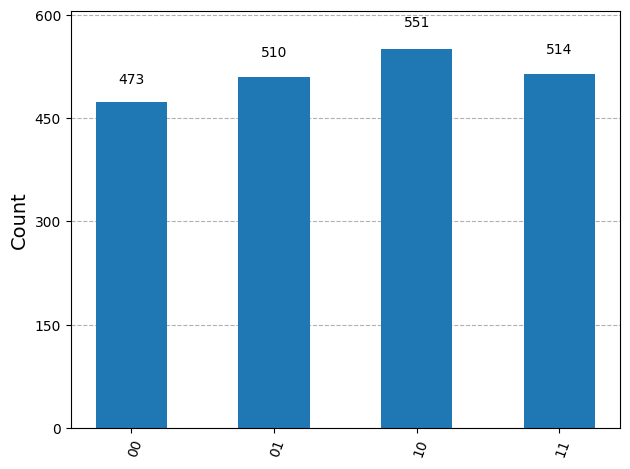

In [15]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram

# Reconnect to IBM Quantum
service = QiskitRuntimeService()

# Load existing job (replace with your Job ID)
job = service.job("d51eco7p3tbc73akec7g")

# Get job result
job_result = job.result()
pub_result = job_result[0]

# Extract measurement counts
counts = pub_result.join_data().get_counts()

print("Bitstring counts:", counts)

# Plot histogram
plot_histogram(counts)
